In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from kernels import *
import pdb
import gpytorch
from itertools import product

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
train_x = torch.linspace(float(0), float(2), int(50))
# The original sin/cos data
#one = torch.sin(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.cos(train_x * (float(2) * math.pi)) + torch.randn(train_x.size()) * float(0.02)

# Polynomials + diff(poly) data
#one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
#two = int(3)*torch.pow(train_x, int(2)) + torch.randn(train_x.size()) * float(0.2)

# Polynomials + diff(poly) data
one = torch.pow(train_x, int(3)) + torch.randn(train_x.size()) * float(0.2)
two = int(6)*train_x + torch.randn(train_x.size()) * float(0.2)

# Combined poly + sin/cos
#one = torch.mul(torch.sin(train_x), train_x)+ torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), train_x) + torch.sin(train_x) + torch.randn(train_x.size()) * float(0.2)

# only sin/cos
#one = torch.mul(torch.sin(train_x), torch.cos(train_x)) + torch.randn(train_x.size()) * float(0.2)
#two = torch.mul(torch.cos(train_x), torch.cos(train_x)) - torch.mul(torch.sin(train_x), torch.sin(train_x)) + torch.randn(train_x.size()) * float(0.2)

train_y = torch.stack([one,two], int(-1))
#train_y = torch.stack([one, two], int(-1))


In [3]:
print(train_x)
print(train_y)
print(np.shape(train_y))

# = torch.Tensor([[float(-0.3), float(0.99)],[float(-0.07), float(1.01)]])

tensor([0.0000, 0.0408, 0.0816, 0.1224, 0.1633, 0.2041, 0.2449, 0.2857, 0.3265,
        0.3673, 0.4082, 0.4490, 0.4898, 0.5306, 0.5714, 0.6122, 0.6531, 0.6939,
        0.7347, 0.7755, 0.8163, 0.8571, 0.8980, 0.9388, 0.9796, 1.0204, 1.0612,
        1.1020, 1.1429, 1.1837, 1.2245, 1.2653, 1.3061, 1.3469, 1.3878, 1.4286,
        1.4694, 1.5102, 1.5510, 1.5918, 1.6327, 1.6735, 1.7143, 1.7551, 1.7959,
        1.8367, 1.8776, 1.9184, 1.9592, 2.0000])
tensor([[ 0.1157,  0.4532],
        [-0.1319,  0.4184],
        [-0.1926,  0.2081],
        [-0.0611,  0.7680],
        [-0.2035,  0.9671],
        [ 0.1819,  1.2515],
        [ 0.0493,  1.2836],
        [ 0.2559,  1.5045],
        [ 0.0716,  1.8419],
        [-0.1462,  2.5104],
        [ 0.0172,  2.6886],
        [ 0.0590,  2.9468],
        [ 0.0476,  2.9994],
        [ 0.1842,  3.2639],
        [ 0.4028,  3.3331],
        [-0.0121,  3.9112],
        [-0.1037,  4.1616],
        [ 0.2871,  4.2027],
        [ 0.6211,  4.4161],
        [ 0.3840,  

In [4]:

len(train_y.shape)

2

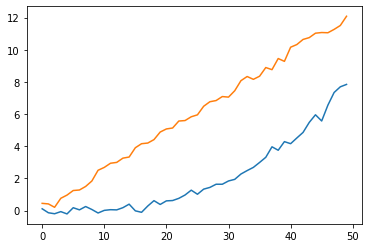

In [5]:
plt.plot(train_y)

$$
\begin{align}
L =& 
\left[
\begin{matrix}
1 & dx_1 \\
0 & 1
\end{matrix}
\right]\\
R =& 
\left[
\begin{matrix}
1 & 0\\
dx_2 & 1
\end{matrix}
\right]\\
\hat{k} =& 
\left[
\begin{matrix}
SE_1 & 0\\
0 & SE_2
\end{matrix}
\right]\\
k =& L*\hat{k}*R\\
=& \left[
\begin{matrix}
dx_1 dx_2 SE_2 + SE_1 & dx_1 SE_2\\
dx_2 SE_2 & SE_2
\end{matrix}
\right]
\end{align}
$$

In [6]:
dx1, dx2, k1, k2, f, g = var('dx1, dx2, k1, k2, f, g')
K = matrix(2,2, (k1, 0, 0, 0))
L = matrix(2, 2, (1, 0, dx1^2, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
L*K*R
# used to see how the data should be created if I 
# decide to create it exactly as I create the kernel
#K = matrix(2,1, (f, g))
#L*L*K

[            k1       dx2^2*k1]
[      dx1^2*k1 dx1^2*dx2^2*k1]

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=2
        )
        kernel = Diff_SE_kernel(var=0, length=0)
        kernel2 = Diff_SE_kernel(var=0, length=0)
        q, dx1, dx2 = var('q, dx1, dx2')
        L = matrix(2, 2, (1, 0, dx1^2, 1))
        R = matrix(2, 2, (1, dx2^2, 0, 1))
        p = DiffMatrixKernel([[kernel, None], [None, None]])
        self.covar_module = p.diff(left_matrix=L, right_matrix=R)
        
        #kernel0 = gpytorch.kernels.RBFKernel()
        #kernel1 = gpytorch.kernels.RBFKernel()
        #kernel2 = gpytorch.kernels.RBFKernel()
        #kernel0 = gpytorch.kernels.PeriodicKernel()
        #kernel1 = gpytorch.kernels.PeriodicKernel()
        #kernel0 = Diff_SE_kernel(var = 0, length=0)
        #kernel1 = Diff_SE_kernel(var = 0, length=0.01)
        #kernel2 = Diff_SE_kernel(var = 0, length=0.02)
        #self.covar_module = MatrixKernel([[kernel0, None], [None, kernel1]])

    def forward(self, x):
        #pdb.set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        #print(f"{covar_x.detach().evaluate()}")
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, validate_args=True)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2, has_global_noise=False, has_task_noise=False)
likelihood._set_task_noises(torch.Tensor([float(0.0001),float(0.0001)]))
#likelihood._set_noise(torch.tensor(float(0.0001)))
model = MultitaskGPModel(train_x, train_y, likelihood)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]


In [8]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = int(2) if smoke_test else int(75)


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.1))  # Includes GaussianLikelihood parameters


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

param_dict = {p[0]:[] for p in model.named_parameters() if 'covar' in p[0]}
param_dict['loss'] = []
param_dict['noise'] = []
if len(likelihood.task_noises) > 1:
    param_dict['task_noises'] = [[] for i in range(len(likelihood.task_noises))]
for p in model.named_parameters():
    if 'covar' in p[0]:
        param_dict[f"{p[0]}_grad"] = []

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    param_dict['loss'].append(loss.item())
    #pdb.set_trace()
    loss.backward()
    for parameter in model.named_parameters():
        if 'covar' in parameter[0]:
            param_dict[parameter[0]].append(parameter[1].item())
            #param_dict[f"{parameter[0]}_grad"].append(parameter[1].grad.item())
    param_dict['noise'].append(likelihood.noise.item())
    for l in range(len(likelihood.task_noises)):
        param_dict['task_noises'][l].append(likelihood.task_noises[l].item())
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f  variance: %.3f noise: %.3f' % (
    #    i + 1, training_iter, loss.item(),
    #    model.covar_module.length.item(),
    #    model.covar_module.var.item(),
    #    model.likelihood.noise.item()
    #))
    optimizer.step()

tensor([[ 1.0000,  1.0000,  0.9992,  ..., -0.4165,  0.1353, -0.4060],
        [ 1.0000,  3.0000,  0.9975,  ..., -0.7772, -0.4060, -0.6767],
        [ 0.9992,  0.9975,  1.0000,  ..., -0.4256,  0.1467, -0.4165],
        ...,
        [-0.4165, -0.7772, -0.4256,  ...,  3.0000,  0.9975,  2.9875],
        [ 0.1353, -0.4060,  0.1467,  ...,  0.9975,  1.0000,  1.0000],
        [-0.4060, -0.6767, -0.4165,  ...,  2.9875,  1.0000,  3.0000]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.1085e+01,  0.0000e+00],
        [ 7.0636e+01,  0.0000e+00],
        [ 3.0563e+01,  0.0000e+00],
        [ 9.6235e+00,  0.0000e+00],
        [ 6.1023e+00,  0.0000e+00],
        [ 1.7105e+00,  0.0000e+00],
        [ 2.5941e-01,  0.0000e+00],
        [ 1.8902e-02,  0.0000e+00],
        [ 1.0844e-03,  0.0000e+00],
        [ 4.9364e-05,  0.0000e+00],
        [ 3.8552e-06,  0.0000e+00],
        [ 2.9899e-06,  1.9000e-06],
        [ 2.9899e-06, -1.9000e-06],
        [-3.2566e-06,  0.0000e+0

/Users/andreas/Documents/container_storage/sage/DiffEqGPs/kernels.py:650: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2897.)
  print(result.eig())


tensor([[ 1.1052,  1.3499,  1.1040,  ..., -0.4776,  0.0961, -0.4559],
        [ 1.3499,  4.9462,  1.3457,  ..., -0.4982, -0.4559, -0.3503],
        [ 1.1040,  1.3457,  1.1052,  ..., -0.4985,  0.1060, -0.4776],
        ...,
        [-0.4776, -0.4982, -0.4985,  ...,  4.9462,  1.3457,  4.9210],
        [ 0.0961, -0.4559,  0.1060,  ...,  1.3457,  1.1052,  1.3499],
        [-0.4559, -0.3503, -0.4776,  ...,  4.9210,  1.3499,  4.9462]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2803e+02,  0.0000e+00],
        [ 9.9201e+01,  0.0000e+00],
        [ 4.5034e+01,  0.0000e+00],
        [ 1.4420e+01,  0.0000e+00],
        [ 1.2075e+01,  0.0000e+00],
        [ 2.8906e+00,  0.0000e+00],
        [ 8.3516e-01,  0.0000e+00],
        [ 7.5115e-02,  0.0000e+00],
        [ 5.2941e-03,  0.0000e+00],
        [ 3.0204e-04,  0.0000e+00],
        [ 1.3438e-05,  0.0000e+00],
        [ 7.2890e-06,  0.0000e+00],
        [-4.9261e-07,  5.0469e-06],
        [-4.9261e-07, -5.0469e-0

tensor([[ 1.3431,  2.4028,  1.3411,  ..., -0.4550,  0.0375, -0.4131],
        [ 2.4028, 12.8959,  2.3921,  ...,  1.2422, -0.4131,  1.3535],
        [ 1.3411,  2.3921,  1.3431,  ..., -0.4989,  0.0433, -0.4550],
        ...,
        [-0.4550,  1.2422, -0.4989,  ..., 12.8959,  2.3921, 12.8000],
        [ 0.0375, -0.4131,  0.0433,  ...,  2.3921,  1.3431,  2.4028],
        [-0.4131,  1.3535, -0.4550,  ..., 12.8000,  2.4028, 12.8959]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.8983e+02,  0.0000e+00],
        [ 2.4237e+02,  0.0000e+00],
        [ 8.5969e+01,  0.0000e+00],
        [ 5.5775e+01,  0.0000e+00],
        [ 2.4707e+01,  0.0000e+00],
        [ 5.6585e+00,  0.0000e+00],
        [ 6.6103e+00,  0.0000e+00],
        [ 9.1929e-01,  0.0000e+00],
        [ 1.0115e-01,  0.0000e+00],
        [ 8.5663e-03,  0.0000e+00],
        [ 6.1935e-04,  0.0000e+00],
        [ 4.0356e-05,  0.0000e+00],
        [-1.4886e-05,  0.0000e+00],
        [ 1.0451e-05,  5.2857e-0

tensor([[ 1.6126e+00,  4.0092e+00,  1.6093e+00,  ..., -2.9006e-01,
          1.1172e-02, -2.4843e-01],
        [ 4.0092e+00,  2.9901e+01,  3.9843e+00,  ...,  3.1069e+00,
         -2.4843e-01,  2.9157e+00],
        [ 1.6093e+00,  3.9843e+00,  1.6126e+00,  ..., -3.3686e-01,
          1.3658e-02, -2.9006e-01],
        ...,
        [-2.9006e-01,  3.1069e+00, -3.3686e-01,  ...,  2.9901e+01,
          3.9843e+00,  2.9593e+01],
        [ 1.1172e-02, -2.4843e-01,  1.3658e-02,  ...,  3.9843e+00,
          1.6126e+00,  4.0092e+00],
        [-2.4843e-01,  2.9157e+00, -2.9006e-01,  ...,  2.9593e+01,
          4.0092e+00,  2.9901e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 5.6982e+02,  0.0000e+00],
        [ 5.6701e+02,  0.0000e+00],
        [ 1.9717e+02,  0.0000e+00],
        [ 1.4929e+02,  0.0000e+00],
        [ 5.1553e+01,  0.0000e+00],
        [ 2.1379e+01,  0.0000e+00],
        [ 1.3425e+01,  0.0000e+00],
        [ 4.7500e+00,  0.0000e+00],
        [ 1.1534e+00,

tensor([[ 1.9065e+00,  6.0224e+00,  1.9015e+00,  ..., -1.5603e-01,
          3.4399e-03, -1.2643e-01],
        [ 6.0224e+00,  5.7070e+01,  5.9749e+00,  ...,  3.4229e+00,
         -1.2643e-01,  2.9805e+00],
        [ 1.9015e+00,  5.9749e+00,  1.9065e+00,  ..., -1.9134e-01,
          4.4401e-03, -1.5603e-01],
        ...,
        [-1.5603e-01,  3.4229e+00, -1.9134e-01,  ...,  5.7070e+01,
          5.9749e+00,  5.6322e+01],
        [ 3.4399e-03, -1.2643e-01,  4.4401e-03,  ...,  5.9749e+00,
          1.9065e+00,  6.0224e+00],
        [-1.2643e-01,  2.9805e+00, -1.5603e-01,  ...,  5.6322e+01,
          6.0224e+00,  5.7070e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0600e+03,  0.0000e+00],
        [ 9.6089e+02,  0.0000e+00],
        [ 4.4881e+02,  0.0000e+00],
        [ 2.7391e+02,  0.0000e+00],
        [ 1.1378e+02,  0.0000e+00],
        [ 4.5743e+01,  0.0000e+00],
        [ 3.0123e+01,  0.0000e+00],
        [ 8.2249e+00,  0.0000e+00],
        [ 6.2202e+00,

tensor([[ 2.2188e+00,  8.1515e+00,  2.2120e+00,  ..., -9.2567e-02,
          1.4292e-03, -7.1910e-02],
        [ 8.1515e+00,  8.9840e+01,  8.0768e+00,  ...,  3.0433e+00,
         -7.1910e-02,  2.5227e+00],
        [ 2.2120e+00,  8.0768e+00,  2.2188e+00,  ..., -1.1830e-01,
          1.9232e-03, -9.2567e-02],
        ...,
        [-9.2567e-02,  3.0433e+00, -1.1830e-01,  ...,  8.9840e+01,
          8.0768e+00,  8.8471e+01],
        [ 1.4292e-03, -7.1910e-02,  1.9232e-03,  ...,  8.0768e+00,
          2.2188e+00,  8.1515e+00],
        [-7.1910e-02,  2.5227e+00, -9.2567e-02,  ...,  8.8471e+01,
          8.1515e+00,  8.9840e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.6052e+03,  0.0000e+00],
        [ 1.4360e+03,  0.0000e+00],
        [ 7.2891e+02,  0.0000e+00],
        [ 4.8181e+02,  0.0000e+00],
        [ 1.7191e+02,  0.0000e+00],
        [ 1.0857e+02,  0.0000e+00],
        [ 3.8696e+01,  0.0000e+00],
        [ 1.6770e+01,  0.0000e+00],
        [ 1.1402e+01,

tensor([[ 2.5424e+00,  9.9315e+00,  2.5341e+00,  ..., -7.7099e-02,
          1.0286e-03, -5.8767e-02],
        [ 9.9315e+00,  1.1639e+02,  9.8348e+00,  ...,  2.9669e+00,
         -5.8767e-02,  2.4078e+00],
        [ 2.5341e+00,  9.8348e+00,  2.5424e+00,  ..., -1.0039e-01,
          1.4104e-03, -7.7099e-02],
        ...,
        [-7.7099e-02,  2.9669e+00, -1.0039e-01,  ...,  1.1639e+02,
          9.8348e+00,  1.1450e+02],
        [ 1.0286e-03, -5.8767e-02,  1.4104e-03,  ...,  9.8348e+00,
          2.5424e+00,  9.9315e+00],
        [-5.8767e-02,  2.4078e+00, -7.7099e-02,  ...,  1.1450e+02,
          9.9315e+00,  1.1639e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.0368e+03,  0.0000e+00],
        [ 1.8340e+03,  0.0000e+00],
        [ 9.3869e+02,  0.0000e+00],
        [ 6.6361e+02,  0.0000e+00],
        [ 2.1416e+02,  0.0000e+00],
        [ 1.6487e+02,  0.0000e+00],
        [ 4.8550e+01,  0.0000e+00],
        [ 2.5116e+01,  0.0000e+00],
        [ 1.4428e+01,

tensor([[ 2.8715e+00,  1.1056e+01,  2.8624e+00,  ..., -9.4129e-02,
          1.3000e-03, -7.2078e-02],
        [ 1.1056e+01,  1.2770e+02,  1.0950e+01,  ...,  3.4911e+00,
         -7.2078e-02,  2.8477e+00],
        [ 2.8624e+00,  1.0950e+01,  2.8715e+00,  ..., -1.2201e-01,
          1.7744e-03, -9.4129e-02],
        ...,
        [-9.4129e-02,  3.4911e+00, -1.2201e-01,  ...,  1.2770e+02,
          1.0950e+01,  1.2566e+02],
        [ 1.3000e-03, -7.2078e-02,  1.7744e-03,  ...,  1.0950e+01,
          2.8715e+00,  1.1056e+01],
        [-7.2078e-02,  2.8477e+00, -9.4129e-02,  ...,  1.2566e+02,
          1.1056e+01,  1.2770e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.2463e+03,  0.0000e+00],
        [ 2.0183e+03,  0.0000e+00],
        [ 1.0323e+03,  0.0000e+00],
        [ 7.1738e+02,  0.0000e+00],
        [ 2.3732e+02,  0.0000e+00],
        [ 1.7434e+02,  0.0000e+00],
        [ 5.3376e+01,  0.0000e+00],
        [ 2.6810e+01,  0.0000e+00],
        [ 1.5867e+01,

tensor([[ 3.2017e+00,  1.1448e+01,  3.1922e+00,  ..., -1.5244e-01,
          2.5096e-03, -1.1937e-01],
        [ 1.1448e+01,  1.2281e+02,  1.1346e+01,  ...,  4.6699e+00,
         -1.1937e-01,  3.9065e+00],
        [ 3.1922e+00,  1.1346e+01,  3.2017e+00,  ..., -1.9329e-01,
          3.3503e-03, -1.5244e-01],
        ...,
        [-1.5244e-01,  4.6699e+00, -1.9329e-01,  ...,  1.2281e+02,
          1.1346e+01,  1.2098e+02],
        [ 2.5096e-03, -1.1937e-01,  3.3503e-03,  ...,  1.1346e+01,
          3.2017e+00,  1.1448e+01],
        [-1.1937e-01,  3.9065e+00, -1.5244e-01,  ...,  1.2098e+02,
          1.1448e+01,  1.2281e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 2.2124e+03,  0.0000e+00],
        [ 1.9777e+03,  0.0000e+00],
        [ 9.9568e+02,  0.0000e+00],
        [ 6.4223e+02,  0.0000e+00],
        [ 2.3836e+02,  0.0000e+00],
        [ 1.3810e+02,  0.0000e+00],
        [ 5.4438e+01,  0.0000e+00],
        [ 2.1099e+01,  0.0000e+00],
        [ 1.5881e+01,

tensor([[ 3.5303e+00,  1.1226e+01,  3.5210e+00,  ..., -2.8129e-01,
          6.1049e-03, -2.2753e-01],
        [ 1.1226e+01,  1.0710e+02,  1.1137e+01,  ...,  6.2864e+00,
         -2.2753e-01,  5.4624e+00],
        [ 3.5210e+00,  1.1137e+01,  3.5303e+00,  ..., -3.4553e-01,
          7.8935e-03, -2.8129e-01],
        ...,
        [-2.8129e-01,  6.2864e+00, -3.4553e-01,  ...,  1.0710e+02,
          1.1137e+01,  1.0569e+02],
        [ 6.1049e-03, -2.2753e-01,  7.8935e-03,  ...,  1.1137e+01,
          3.5303e+00,  1.1226e+01],
        [-2.2753e-01,  5.4624e+00, -2.8129e-01,  ...,  1.0569e+02,
          1.1226e+01,  1.0710e+02]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.9867e+03,  0.0000e+00],
        [ 1.7982e+03,  0.0000e+00],
        [ 8.4462e+02,  0.0000e+00],
        [ 5.1557e+02,  0.0000e+00],
        [ 2.1365e+02,  0.0000e+00],
        [ 8.7442e+01,  0.0000e+00],
        [ 5.5961e+01,  0.0000e+00],
        [ 1.5343e+01,  0.0000e+00],
        [ 1.1989e+01,

tensor([[ 3.8576e+00,  1.0622e+01,  3.8488e+00,  ..., -5.1524e-01,
          1.5654e-02, -4.3164e-01],
        [ 1.0622e+01,  8.7746e+01,  1.0549e+01,  ...,  7.6048e+00,
         -4.3164e-01,  6.9108e+00],
        [ 3.8488e+00,  1.0549e+01,  3.8576e+00,  ..., -6.1150e-01,
          1.9554e-02, -5.1524e-01],
        ...,
        [-5.1524e-01,  7.6048e+00, -6.1150e-01,  ...,  8.7746e+01,
          1.0549e+01,  8.6743e+01],
        [ 1.5654e-02, -4.3164e-01,  1.9554e-02,  ...,  1.0549e+01,
          3.8576e+00,  1.0622e+01],
        [-4.3164e-01,  6.9108e+00, -5.1524e-01,  ...,  8.6743e+01,
          1.0622e+01,  8.7746e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.6625e+03,  0.0000e+00],
        [ 1.5764e+03,  0.0000e+00],
        [ 6.3446e+02,  0.0000e+00],
        [ 4.1714e+02,  0.0000e+00],
        [ 1.6429e+02,  0.0000e+00],
        [ 5.6446e+01,  0.0000e+00],
        [ 4.8847e+01,  0.0000e+00],
        [ 1.3958e+01,  0.0000e+00],
        [ 5.3615e+00,

tensor([[ 4.1864e+00,  9.8450e+00,  4.1782e+00,  ..., -8.6626e-01,
          3.7951e-02, -7.5027e-01],
        [ 9.8450e+00,  6.9456e+01,  9.7872e+00,  ...,  7.6951e+00,
         -7.5027e-01,  7.3551e+00],
        [ 4.1782e+00,  9.7872e+00,  4.1864e+00,  ..., -9.9506e-01,
          4.5893e-02, -8.6626e-01],
        ...,
        [-8.6626e-01,  7.6951e+00, -9.9506e-01,  ...,  6.9456e+01,
          9.7872e+00,  6.8777e+01],
        [ 3.7951e-02, -7.5027e-01,  4.5893e-02,  ...,  9.7872e+00,
          4.1864e+00,  9.8450e+00],
        [-7.5027e-01,  7.3551e+00, -8.6626e-01,  ...,  6.8777e+01,
          9.8450e+00,  6.9456e+01]], grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.3572e+03,  0.0000e+00],
        [ 1.3240e+03,  0.0000e+00],
        [ 4.3164e+02,  0.0000e+00],
        [ 3.6088e+02,  0.0000e+00],
        [ 1.1565e+02,  0.0000e+00],
        [ 5.0905e+01,  0.0000e+00],
        [ 2.8957e+01,  0.0000e+00],
        [ 1.0482e+01,  0.0000e+00],
        [ 2.0691e+00,

tensor([[ 4.5201,  9.0113,  4.5126,  ..., -1.3064,  0.0839, -1.1659],
        [ 9.0113, 53.8950,  8.9664,  ...,  6.1249, -1.1659,  6.2472],
        [ 4.5126,  8.9664,  4.5201,  ..., -1.4571,  0.0985, -1.3064],
        ...,
        [-1.3064,  6.1249, -1.4571,  ..., 53.8950,  8.9664, 53.4484],
        [ 0.0839, -1.1659,  0.0985,  ...,  8.9664,  4.5201,  9.0113],
        [-1.1659,  6.2472, -1.3064,  ..., 53.4484,  9.0113, 53.8950]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1490e+03,  0.0000e+00],
        [ 1.0200e+03,  0.0000e+00],
        [ 3.2397e+02,  0.0000e+00],
        [ 2.7231e+02,  0.0000e+00],
        [ 9.2593e+01,  0.0000e+00],
        [ 3.4568e+01,  0.0000e+00],
        [ 2.1952e+01,  0.0000e+00],
        [ 5.5508e+00,  0.0000e+00],
        [ 7.2524e-01,  0.0000e+00],
        [ 6.8563e-02,  0.0000e+00],
        [ 5.4727e-03,  0.0000e+00],
        [ 3.9227e-04,  0.0000e+00],
        [-5.6904e-05,  1.1692e-05],
        [-5.6904e-05, -1.1692e-0

tensor([[ 4.8647,  8.2371,  4.8579,  ..., -1.7570,  0.1646, -1.6086],
        [ 8.2371, 41.8419,  8.2023,  ...,  3.3785, -1.6086,  3.8853],
        [ 4.8579,  8.2023,  4.8647,  ..., -1.9110,  0.1887, -1.7570],
        ...,
        [-1.7570,  3.3785, -1.9110,  ..., 41.8419,  8.2023, 41.5473],
        [ 0.1646, -1.6086,  0.1887,  ...,  8.2023,  4.8647,  8.2371],
        [-1.6086,  3.8853, -1.7570,  ..., 41.5473,  8.2371, 41.8419]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 9.6409e+02,  0.0000e+00],
        [ 7.8466e+02,  0.0000e+00],
        [ 2.9382e+02,  0.0000e+00],
        [ 1.6653e+02,  0.0000e+00],
        [ 8.5586e+01,  0.0000e+00],
        [ 1.9241e+01,  0.0000e+00],
        [ 1.8697e+01,  0.0000e+00],
        [ 2.4298e+00,  0.0000e+00],
        [ 2.4824e-01,  0.0000e+00],
        [ 1.9875e-02,  0.0000e+00],
        [ 1.3570e-03,  0.0000e+00],
        [ 1.0406e-04,  0.0000e+00],
        [-5.1591e-05,  0.0000e+00],
        [-4.3706e-05,  0.0000e+0

tensor([[ 5.2319,  7.6587,  5.2255,  ..., -2.1309,  0.2800, -1.9902],
        [ 7.6587, 33.6335,  7.6307,  ...,  0.5797, -1.9902,  1.2920],
        [ 5.2255,  7.6307,  5.2319,  ..., -2.2726,  0.3152, -2.1309],
        ...,
        [-2.1309,  0.5797, -2.2726,  ..., 33.6335,  7.6307, 33.4288],
        [ 0.2800, -1.9902,  0.3152,  ...,  7.6307,  5.2319,  7.6587],
        [-1.9902,  1.2920, -2.1309,  ..., 33.4288,  7.6587, 33.6335]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.2191e+02,  0.0000e+00],
        [ 6.3520e+02,  0.0000e+00],
        [ 2.6866e+02,  0.0000e+00],
        [ 1.0680e+02,  0.0000e+00],
        [ 8.1964e+01,  0.0000e+00],
        [ 1.7547e+01,  0.0000e+00],
        [ 9.9921e+00,  0.0000e+00],
        [ 1.0962e+00,  0.0000e+00],
        [ 9.4033e-02,  0.0000e+00],
        [ 6.4779e-03,  0.0000e+00],
        [ 3.8421e-04,  0.0000e+00],
        [ 4.2984e-05,  0.0000e+00],
        [-4.7111e-05,  0.0000e+00],
        [-4.1025e-05,  1.2228e-0

tensor([[ 5.6345,  7.3390,  5.6284,  ..., -2.4100,  0.4164, -2.2834],
        [ 7.3390, 28.6775,  7.3151,  ..., -1.5710, -2.2834, -0.7881],
        [ 5.6284,  7.3151,  5.6345,  ..., -2.5339,  0.4626, -2.4100],
        ...,
        [-2.4100, -1.5710, -2.5339,  ..., 28.6775,  7.3151, 28.5221],
        [ 0.4164, -2.2834,  0.4626,  ...,  7.3151,  5.6345,  7.3390],
        [-2.2834, -0.7881, -2.4100,  ..., 28.5221,  7.3390, 28.6775]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.2877e+02,  0.0000e+00],
        [ 5.5822e+02,  0.0000e+00],
        [ 2.5030e+02,  0.0000e+00],
        [ 7.9066e+01,  0.0000e+00],
        [ 7.6419e+01,  0.0000e+00],
        [ 1.6256e+01,  0.0000e+00],
        [ 5.9502e+00,  0.0000e+00],
        [ 5.7363e-01,  0.0000e+00],
        [ 4.3289e-02,  0.0000e+00],
        [ 2.6493e-03,  0.0000e+00],
        [ 1.3344e-04,  0.0000e+00],
        [-1.7371e-05,  2.6430e-05],
        [-1.7371e-05, -2.6430e-05],
        [ 3.0835e-05,  0.0000e+0

tensor([[ 6.0821,  7.2641,  6.0760,  ..., -2.6309,  0.5580, -2.5175],
        [ 7.2641, 26.0279,  7.2425,  ..., -3.0592, -2.5175, -2.2613],
        [ 6.0760,  7.2425,  6.0821,  ..., -2.7392,  0.6146, -2.6309],
        ...,
        [-2.6309, -3.0592, -2.7392,  ..., 26.0279,  7.2425, 25.8986],
        [ 0.5580, -2.5175,  0.6146,  ...,  7.2425,  6.0821,  7.2641],
        [-2.5175, -2.2613, -2.6309,  ..., 25.8986,  7.2641, 26.0279]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.7770e+02,  0.0000e+00],
        [ 5.2879e+02,  0.0000e+00],
        [ 2.4026e+02,  0.0000e+00],
        [ 7.7176e+01,  0.0000e+00],
        [ 6.1786e+01,  0.0000e+00],
        [ 1.5320e+01,  0.0000e+00],
        [ 4.0856e+00,  0.0000e+00],
        [ 3.5877e-01,  0.0000e+00],
        [ 2.4699e-02,  0.0000e+00],
        [ 1.3857e-03,  0.0000e+00],
        [ 7.1381e-05,  0.0000e+00],
        [ 3.4267e-05,  0.0000e+00],
        [-3.0573e-05,  0.0000e+00],
        [ 2.8133e-05,  0.0000e+0

tensor([[ 6.5799,  7.3959,  6.5737,  ..., -2.8349,  0.6949, -2.7306],
        [ 7.3959, 24.9396,  7.3752,  ..., -4.1072, -2.7306, -3.3024],
        [ 6.5737,  7.3752,  6.5799,  ..., -2.9323,  0.7609, -2.8349],
        ...,
        [-2.8349, -4.1072, -2.9323,  ..., 24.9396,  7.3752, 24.8230],
        [ 0.6949, -2.7306,  0.7609,  ...,  7.3752,  6.5799,  7.3959],
        [-2.7306, -3.3024, -2.8349,  ..., 24.8230,  7.3959, 24.9396]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.5891e+02,  0.0000e+00],
        [ 5.2814e+02,  0.0000e+00],
        [ 2.3846e+02,  0.0000e+00],
        [ 7.6850e+01,  0.0000e+00],
        [ 5.5323e+01,  0.0000e+00],
        [ 1.4799e+01,  0.0000e+00],
        [ 3.2038e+00,  0.0000e+00],
        [ 2.6378e-01,  0.0000e+00],
        [ 1.7042e-02,  0.0000e+00],
        [ 8.9466e-04,  0.0000e+00],
        [ 4.6260e-05,  0.0000e+00],
        [-3.0490e-05,  8.4337e-06],
        [-3.0490e-05, -8.4337e-06],
        [ 2.5338e-05,  0.0000e+0

tensor([[ 7.1298,  7.7002,  7.1234,  ..., -3.0480,  0.8223, -2.9483],
        [ 7.7002, 24.9486,  7.6794,  ..., -4.9060, -2.9483, -4.0834],
        [ 7.1234,  7.6794,  7.1298,  ..., -3.1395,  0.8972, -3.0480],
        ...,
        [-3.0480, -4.9060, -3.1395,  ..., 24.9486,  7.6794, 24.8365],
        [ 0.8223, -2.9483,  0.8972,  ...,  7.6794,  7.1298,  7.7002],
        [-2.9483, -4.0834, -3.0480,  ..., 24.8365,  7.7002, 24.9486]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.6482e+02,  0.0000e+00],
        [ 5.4578e+02,  0.0000e+00],
        [ 2.4385e+02,  0.0000e+00],
        [ 7.8351e+01,  0.0000e+00],
        [ 5.3346e+01,  0.0000e+00],
        [ 1.4734e+01,  0.0000e+00],
        [ 2.8032e+00,  0.0000e+00],
        [ 2.2129e-01,  0.0000e+00],
        [ 1.3724e-02,  0.0000e+00],
        [ 6.8887e-04,  0.0000e+00],
        [ 3.1250e-05,  0.0000e+00],
        [-3.0880e-05,  0.0000e+00],
        [-7.1436e-06,  2.4199e-05],
        [-7.1436e-06, -2.4199e-0

tensor([[ 7.7314,  8.1496,  7.7246,  ..., -3.2831,  0.9390, -3.1837],
        [ 8.1496, 25.7712,  8.1281,  ..., -5.5737, -3.1837, -4.7165],
        [ 7.7246,  8.1281,  7.7314,  ..., -3.3733,  1.0225, -3.2831],
        ...,
        [-3.2831, -5.5737, -3.3733,  ..., 25.7712,  8.1281, 25.6582],
        [ 0.9390, -3.1837,  1.0225,  ...,  8.1281,  7.7314,  8.1496],
        [-3.1837, -4.7165, -3.2831,  ..., 25.6582,  8.1496, 25.7712]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 6.9004e+02,  0.0000e+00],
        [ 5.7614e+02,  0.0000e+00],
        [ 2.5522e+02,  0.0000e+00],
        [ 8.1659e+01,  0.0000e+00],
        [ 5.4077e+01,  0.0000e+00],
        [ 1.5109e+01,  0.0000e+00],
        [ 2.6674e+00,  0.0000e+00],
        [ 2.0530e-01,  0.0000e+00],
        [ 1.2407e-02,  0.0000e+00],
        [ 6.0594e-04,  0.0000e+00],
        [ 3.3878e-05,  0.0000e+00],
        [-2.7969e-05,  0.0000e+00],
        [ 1.6142e-05,  2.1943e-05],
        [ 1.6142e-05, -2.1943e-0

tensor([[ 8.3815,  8.7181,  8.3742,  ..., -3.5440,  1.0467, -3.4413],
        [ 8.7181, 27.2051,  8.6955,  ..., -6.1773, -3.4413, -5.2695],
        [ 8.3742,  8.6955,  8.3815,  ..., -3.6364,  1.1385, -3.5440],
        ...,
        [-3.5440, -6.1773, -3.6364,  ..., 27.2051,  8.6955, 27.0873],
        [ 1.0467, -3.4413,  1.1385,  ...,  8.6955,  8.3815,  8.7181],
        [-3.4413, -5.2695, -3.5440,  ..., 27.0873,  8.7181, 27.2051]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.3026e+02,  0.0000e+00],
        [ 6.1582e+02,  0.0000e+00],
        [ 2.7135e+02,  0.0000e+00],
        [ 8.6550e+01,  0.0000e+00],
        [ 5.6567e+01,  0.0000e+00],
        [ 1.5863e+01,  0.0000e+00],
        [ 2.6915e+00,  0.0000e+00],
        [ 2.0429e-01,  0.0000e+00],
        [ 1.2198e-02,  0.0000e+00],
        [ 6.0317e-04,  0.0000e+00],
        [ 3.2557e-05,  0.0000e+00],
        [ 2.9491e-05,  8.3960e-06],
        [ 2.9491e-05, -8.3960e-06],
        [-3.0903e-05,  0.0000e+0

tensor([[ 9.0750,  9.3773,  9.0672,  ..., -3.8285,  1.1490, -3.7201],
        [ 9.3773, 29.0687,  9.3531,  ..., -6.7569, -3.7201, -5.7856],
        [ 9.0672,  9.3531,  9.0750,  ..., -3.9256,  1.2491, -3.8285],
        ...,
        [-3.8285, -6.7569, -3.9256,  ..., 29.0687,  9.3531, 28.9437],
        [ 1.1490, -3.7201,  1.2491,  ...,  9.3531,  9.0750,  9.3773],
        [-3.7201, -5.7856, -3.8285,  ..., 28.9437,  9.3773, 29.0687]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 7.8123e+02,  0.0000e+00],
        [ 6.6222e+02,  0.0000e+00],
        [ 2.9098e+02,  0.0000e+00],
        [ 9.2643e+01,  0.0000e+00],
        [ 6.0187e+01,  0.0000e+00],
        [ 1.6897e+01,  0.0000e+00],
        [ 2.8117e+00,  0.0000e+00],
        [ 2.1196e-01,  0.0000e+00],
        [ 1.2565e-02,  0.0000e+00],
        [ 6.1636e-04,  0.0000e+00],
        [ 4.2789e-05,  0.0000e+00],
        [-3.7330e-05,  8.4798e-06],
        [-3.7330e-05, -8.4798e-06],
        [ 2.9510e-05,  2.2724e-0

tensor([[ 9.8055, 10.0941,  9.7971,  ..., -4.1311,  1.2512, -4.0156],
        [10.0941, 31.1735, 10.0681,  ..., -7.3412, -4.0156, -6.2989],
        [ 9.7971, 10.0681,  9.8055,  ..., -4.2343,  1.3597, -4.1311],
        ...,
        [-4.1311, -7.3412, -4.2343,  ..., 31.1735, 10.0681, 31.0400],
        [ 1.2512, -4.0156,  1.3597,  ..., 10.0681,  9.8055, 10.0941],
        [-4.0156, -6.2989, -4.1311,  ..., 31.0400, 10.0941, 31.1735]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.3837e+02,  0.0000e+00],
        [ 7.1277e+02,  0.0000e+00],
        [ 3.1267e+02,  0.0000e+00],
        [ 9.9445e+01,  0.0000e+00],
        [ 6.4396e+01,  0.0000e+00],
        [ 1.8086e+01,  0.0000e+00],
        [ 2.9770e+00,  0.0000e+00],
        [ 2.2352e-01,  0.0000e+00],
        [ 1.3195e-02,  0.0000e+00],
        [ 6.2948e-04,  0.0000e+00],
        [ 4.4896e-05,  3.1193e-06],
        [ 4.4896e-05, -3.1193e-06],
        [-3.6756e-05,  5.1242e-06],
        [-3.6756e-05, -5.1242e-0

tensor([[10.5652, 10.8319, 10.5561,  ..., -4.4444,  1.3594, -4.3220],
        [10.8319, 33.3162, 10.8042,  ..., -7.9561, -4.3220, -6.8415],
        [10.5561, 10.8042, 10.5652,  ..., -4.5536,  1.4768, -4.4444],
        ...,
        [-4.4444, -7.9561, -4.5536,  ..., 33.3162, 10.8042, 33.1741],
        [ 1.3594, -4.3220,  1.4768,  ..., 10.8042, 10.5652, 10.8319],
        [-4.3220, -6.8415, -4.4444,  ..., 33.1741, 10.8319, 33.3162]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 8.9664e+02,  0.0000e+00],
        [ 7.6481e+02,  0.0000e+00],
        [ 3.3490e+02,  0.0000e+00],
        [ 1.0638e+02,  0.0000e+00],
        [ 6.8656e+01,  0.0000e+00],
        [ 1.9288e+01,  0.0000e+00],
        [ 3.1377e+00,  0.0000e+00],
        [ 2.3462e-01,  0.0000e+00],
        [ 1.3788e-02,  0.0000e+00],
        [ 6.4955e-04,  0.0000e+00],
        [ 4.8714e-05,  0.0000e+00],
        [-3.7813e-05,  0.0000e+00],
        [-3.1523e-05,  1.4106e-05],
        [-3.1523e-05, -1.4106e-0

tensor([[11.3462, 11.5527, 11.3366,  ..., -4.7605,  1.4807, -4.6326],
        [11.5527, 35.2887, 11.5233,  ..., -8.6252, -4.6326, -7.4436],
        [11.3366, 11.5233, 11.3462,  ..., -4.8740,  1.6076, -4.7605],
        ...,
        [-4.7605, -8.6252, -4.8740,  ..., 35.2887, 11.5233, 35.1392],
        [ 1.4807, -4.6326,  1.6076,  ..., 11.5233, 11.3462, 11.5527],
        [-4.6326, -7.4436, -4.7605,  ..., 35.1392, 11.5527, 35.2887]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 9.5088e+02,  0.0000e+00],
        [ 8.1568e+02,  0.0000e+00],
        [ 3.5604e+02,  0.0000e+00],
        [ 1.1285e+02,  0.0000e+00],
        [ 7.2437e+01,  0.0000e+00],
        [ 2.0352e+01,  0.0000e+00],
        [ 3.2460e+00,  0.0000e+00],
        [ 2.4097e-01,  0.0000e+00],
        [ 1.4069e-02,  0.0000e+00],
        [ 6.7509e-04,  0.0000e+00],
        [-4.4458e-05,  0.0000e+00],
        [ 4.2248e-05,  2.9261e-06],
        [ 4.2248e-05, -2.9261e-06],
        [ 2.9413e-05,  2.5556e-0

tensor([[12.1413, 12.2201, 12.1311,  ..., -5.0703,  1.6219, -4.9398],
        [12.2201, 36.8983, 12.1894,  ..., -9.3653, -4.9398, -8.1289],
        [12.1311, 12.1894, 12.1413,  ..., -5.1852,  1.7594, -5.0703],
        ...,
        [-5.0703, -9.3653, -5.1852,  ..., 36.8983, 12.1894, 36.7438],
        [ 1.6219, -4.9398,  1.7594,  ..., 12.1894, 12.1413, 12.2201],
        [-4.9398, -8.1289, -5.0703,  ..., 36.7438, 12.2201, 36.8983]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 9.9623e+02,  0.0000e+00],
        [ 8.6297e+02,  0.0000e+00],
        [ 3.7460e+02,  0.0000e+00],
        [ 1.1825e+02,  0.0000e+00],
        [ 7.5286e+01,  0.0000e+00],
        [ 2.1129e+01,  0.0000e+00],
        [ 3.2623e+00,  0.0000e+00],
        [ 2.3928e-01,  0.0000e+00],
        [ 1.3799e-02,  0.0000e+00],
        [ 6.4526e-04,  0.0000e+00],
        [ 5.2146e-05,  0.0000e+00],
        [-3.8008e-05,  2.6329e-05],
        [-3.8008e-05, -2.6329e-05],
        [ 4.6372e-05,  0.0000e+0

tensor([[ 12.9440,  12.8033,  12.9333,  ...,  -5.3645,   1.7903,  -5.2355],
        [ 12.8033,  37.9922,  12.7716,  ..., -10.1797,  -5.2355,  -8.9069],
        [ 12.9333,  12.7716,  12.9440,  ...,  -5.4765,   1.9392,  -5.3645],
        ...,
        [ -5.3645, -10.1797,  -5.4765,  ...,  37.9922,  12.7716,  37.8358],
        [  1.7903,  -5.2355,   1.9392,  ...,  12.7716,  12.9440,  12.8033],
        [ -5.2355,  -8.9069,  -5.3645,  ...,  37.8358,  12.8033,  37.9922]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0287e+03,  0.0000e+00],
        [ 9.0492e+02,  0.0000e+00],
        [ 3.8935e+02,  0.0000e+00],
        [ 1.2203e+02,  0.0000e+00],
        [ 7.6915e+01,  0.0000e+00],
        [ 2.1491e+01,  0.0000e+00],
        [ 3.1640e+00,  0.0000e+00],
        [ 2.2793e-01,  0.0000e+00],
        [ 1.2919e-02,  0.0000e+00],
        [ 6.0043e-04,  0.0000e+00],
        [ 3.3530e-05,  2.4882e-05],
        [ 3.3530e-05, -2.4882e-05],
        [-1.5924e-05,  3.4465e-0

tensor([[ 13.7497,  13.2802,  13.7387,  ...,  -5.6326,   1.9924,  -5.5101],
        [ 13.2802,  38.4798,  13.2481,  ..., -11.0515,  -5.5101,  -9.7661],
        [ 13.7387,  13.2481,  13.7497,  ...,  -5.7367,   2.1541,  -5.6326],
        ...,
        [ -5.6326, -11.0515,  -5.7367,  ...,  38.4798,  13.2481,  38.3252],
        [  1.9924,  -5.5101,   2.1541,  ...,  13.2481,  13.7497,  13.2802],
        [ -5.5101,  -9.7661,  -5.6326,  ...,  38.3252,  13.2802,  38.4798]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0457e+03,  0.0000e+00],
        [ 9.4070e+02,  0.0000e+00],
        [ 3.9948e+02,  0.0000e+00],
        [ 1.2378e+02,  0.0000e+00],
        [ 7.7261e+01,  0.0000e+00],
        [ 2.1342e+01,  0.0000e+00],
        [ 2.9517e+00,  0.0000e+00],
        [ 2.0746e-01,  0.0000e+00],
        [ 1.1476e-02,  0.0000e+00],
        [ 5.1297e-04,  0.0000e+00],
        [-5.2365e-05,  0.0000e+00],
        [ 4.9532e-05,  0.0000e+00],
        [ 4.3592e-05,  0.0000e+0

tensor([[ 14.5559,  13.6400,  14.5445,  ...,  -5.8643,   2.2341,  -5.7537],
        [ 13.6400,  38.3454,  13.6081,  ..., -11.9427,  -5.7537, -10.6722],
        [ 14.5445,  13.6081,  14.5559,  ...,  -5.9550,   2.4098,  -5.8643],
        ...,
        [ -5.8643, -11.9427,  -5.9550,  ...,  38.3454,  13.6081,  38.1959],
        [  2.2341,  -5.7537,   2.4098,  ...,  13.6081,  14.5559,  13.6400],
        [ -5.7537, -10.6722,  -5.8643,  ...,  38.1959,  13.6400,  38.3454]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0466e+03,  0.0000e+00],
        [ 9.7053e+02,  0.0000e+00],
        [ 4.0479e+02,  0.0000e+00],
        [ 1.2321e+02,  0.0000e+00],
        [ 7.6491e+01,  0.0000e+00],
        [ 2.0641e+01,  0.0000e+00],
        [ 2.6484e+00,  0.0000e+00],
        [ 1.8043e-01,  0.0000e+00],
        [ 9.6778e-03,  0.0000e+00],
        [ 4.2674e-04,  0.0000e+00],
        [ 4.6448e-05,  0.0000e+00],
        [-4.0587e-05,  0.0000e+00],
        [ 4.1543e-05,  0.0000e+0

tensor([[ 15.3621,  13.8846,  15.3505,  ...,  -6.0501,   2.5200,  -5.9567],
        [ 13.8846,  37.6476,  13.8532,  ..., -12.7996,  -5.9567, -11.5721],
        [ 15.3505,  13.8532,  15.3621,  ...,  -6.1222,   2.7109,  -6.0501],
        ...,
        [ -6.0501, -12.7996,  -6.1222,  ...,  37.6476,  13.8532,  37.5060],
        [  2.5200,  -5.9567,   2.7109,  ...,  13.8532,  15.3621,  13.8846],
        [ -5.9567, -11.5721,  -6.0501,  ...,  37.5060,  13.8846,  37.6476]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0322e+03,  0.0000e+00],
        [ 9.9552e+02,  0.0000e+00],
        [ 4.0563e+02,  0.0000e+00],
        [ 1.2030e+02,  0.0000e+00],
        [ 7.4931e+01,  0.0000e+00],
        [ 1.9419e+01,  0.0000e+00],
        [ 2.2917e+00,  0.0000e+00],
        [ 1.5044e-01,  0.0000e+00],
        [ 7.7695e-03,  0.0000e+00],
        [ 3.1796e-04,  0.0000e+00],
        [ 4.1712e-05,  1.9505e-05],
        [ 4.1712e-05, -1.9505e-05],
        [-3.0415e-05,  3.2932e-0

tensor([[ 16.1703,  14.0285,  16.1586,  ...,  -6.1839,   2.8522,  -6.1122],
        [ 14.0285,  36.5109,  13.9981,  ..., -13.5644,  -6.1122, -12.4054],
        [ 16.1586,  13.9981,  16.1703,  ...,  -6.2331,   3.0593,  -6.1839],
        ...,
        [ -6.1839, -13.5644,  -6.2331,  ...,  36.5109,  13.9981,  36.3791],
        [  2.8522,  -6.1122,   3.0593,  ...,  13.9981,  16.1703,  14.0285],
        [ -6.1122, -12.4054,  -6.1839,  ...,  36.3791,  14.0285,  36.5109]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0174e+03,  0.0000e+00],
        [ 1.0056e+03,  0.0000e+00],
        [ 4.0289e+02,  0.0000e+00],
        [ 1.1531e+02,  0.0000e+00],
        [ 7.2972e+01,  0.0000e+00],
        [ 1.7794e+01,  0.0000e+00],
        [ 1.9242e+00,  0.0000e+00],
        [ 1.2113e-01,  0.0000e+00],
        [ 6.0110e-03,  0.0000e+00],
        [ 2.4794e-04,  0.0000e+00],
        [-4.4612e-05,  5.8085e-07],
        [-4.4612e-05, -5.8085e-07],
        [ 3.8807e-05,  1.2414e-0

tensor([[ 16.9850,  14.0992,  16.9733,  ...,  -6.2663,   3.2289,  -6.2193],
        [ 14.0992,  35.1111,  14.0700,  ..., -14.1929,  -6.2193, -13.1210],
        [ 16.9733,  14.0700,  16.9850,  ...,  -6.2896,   3.4529,  -6.2663],
        ...,
        [ -6.2663, -14.1929,  -6.2896,  ...,  35.1111,  14.0700,  34.9898],
        [  3.2289,  -6.2193,   3.4529,  ...,  14.0700,  16.9850,  14.0992],
        [ -6.2193, -13.1210,  -6.2663,  ...,  34.9898,  14.0992,  35.1111]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0384e+03,  0.0000e+00],
        [ 9.7100e+02,  0.0000e+00],
        [ 3.9791e+02,  0.0000e+00],
        [ 1.0883e+02,  0.0000e+00],
        [ 7.0982e+01,  0.0000e+00],
        [ 1.5953e+01,  0.0000e+00],
        [ 1.5825e+00,  0.0000e+00],
        [ 9.5237e-02,  0.0000e+00],
        [ 4.5189e-03,  0.0000e+00],
        [ 1.7968e-04,  0.0000e+00],
        [-4.7247e-05,  0.0000e+00],
        [-4.3014e-05,  8.4133e-06],
        [-4.3014e-05, -8.4133e-0

tensor([[ 17.8129,  14.1364,  17.8011,  ...,  -6.3069,   3.6427,  -6.2859],
        [ 14.1364,  33.6560,  14.1084,  ..., -14.6714,  -6.2859, -13.6953],
        [ 17.8011,  14.1084,  17.8129,  ...,  -6.3034,   3.8839,  -6.3069],
        ...,
        [ -6.3069, -14.6714,  -6.3034,  ...,  33.6560,  14.1084,  33.5449],
        [  3.6427,  -6.2859,   3.8839,  ...,  14.1084,  17.8129,  14.1364],
        [ -6.2859, -13.6953,  -6.3069,  ...,  33.5449,  14.1364,  33.6560]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0607e+03,  0.0000e+00],
        [ 9.3394e+02,  0.0000e+00],
        [ 3.9230e+02,  0.0000e+00],
        [ 1.0171e+02,  0.0000e+00],
        [ 6.9266e+01,  0.0000e+00],
        [ 1.4118e+01,  0.0000e+00],
        [ 1.2921e+00,  0.0000e+00],
        [ 7.4270e-02,  0.0000e+00],
        [ 3.3655e-03,  0.0000e+00],
        [ 1.3442e-04,  0.0000e+00],
        [-4.9918e-05,  1.5824e-06],
        [-4.9918e-05, -1.5824e-06],
        [ 4.1138e-05,  8.7081e-0

tensor([[ 18.6626,  14.1885,  18.6508,  ...,  -6.3263,   4.0796,  -6.3305],
        [ 14.1885,  32.3612,  14.1616,  ..., -15.0276,  -6.3305, -14.1440],
        [ 18.6508,  14.1616,  18.6626,  ...,  -6.2972,   4.3380,  -6.3263],
        ...,
        [ -6.3263, -15.0276,  -6.2972,  ...,  32.3612,  14.1616,  32.2588],
        [  4.0796,  -6.3305,   4.3380,  ...,  14.1616,  18.6626,  14.1885],
        [ -6.3305, -14.1440,  -6.3263,  ...,  32.2588,  14.1885,  32.3612]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.0865e+03,  0.0000e+00],
        [ 9.0033e+02,  0.0000e+00],
        [ 3.8776e+02,  0.0000e+00],
        [ 9.4945e+01,  0.0000e+00],
        [ 6.8067e+01,  0.0000e+00],
        [ 1.2495e+01,  0.0000e+00],
        [ 1.0649e+00,  0.0000e+00],
        [ 5.8607e-02,  0.0000e+00],
        [ 2.5480e-03,  0.0000e+00],
        [ 8.2819e-05,  0.0000e+00],
        [-1.2591e-05,  4.0105e-05],
        [-1.2591e-05, -4.0105e-05],
        [-4.5142e-05,  0.0000e+0

tensor([[ 19.5435,  14.3064,  19.5316,  ...,  -6.3536,   4.5203,  -6.3802],
        [ 14.3064,  31.4181,  14.2802,  ..., -15.3264,  -6.3802, -14.5212],
        [ 19.5316,  14.2802,  19.5435,  ...,  -6.3016,   4.7958,  -6.3536],
        ...,
        [ -6.3536, -15.3264,  -6.3016,  ...,  31.4181,  14.2802,  31.3224],
        [  4.5203,  -6.3802,   4.7958,  ...,  14.2802,  19.5435,  14.3064],
        [ -6.3802, -14.5212,  -6.3536,  ...,  31.3224,  14.3064,  31.4181]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1173e+03,  0.0000e+00],
        [ 8.7567e+02,  0.0000e+00],
        [ 3.8594e+02,  0.0000e+00],
        [ 8.9441e+01,  0.0000e+00],
        [ 6.7569e+01,  0.0000e+00],
        [ 1.1223e+01,  0.0000e+00],
        [ 9.0172e-01,  0.0000e+00],
        [ 4.7775e-02,  0.0000e+00],
        [ 2.0167e-03,  0.0000e+00],
        [ 6.2304e-05,  0.0000e+00],
        [-4.2951e-05,  1.2555e-05],
        [-4.2951e-05, -1.2555e-05],
        [ 4.8463e-05,  0.0000e+0

tensor([[ 20.4639,  14.5330,  20.4518,  ...,  -6.4188,   4.9447,  -6.4638],
        [ 14.5330,  30.9631,  14.5073,  ..., -15.6485,  -6.4638, -14.8998],
        [ 20.4518,  14.5073,  20.4639,  ...,  -6.3477,   5.2367,  -6.4188],
        ...,
        [ -6.4188, -15.6485,  -6.3477,  ...,  30.9631,  14.5073,  30.8716],
        [  4.9447,  -6.4638,   5.2367,  ...,  14.5073,  20.4639,  14.5330],
        [ -6.4638, -14.8998,  -6.4188,  ...,  30.8716,  14.5330,  30.9631]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1543e+03,  0.0000e+00],
        [ 8.6398e+02,  0.0000e+00],
        [ 3.8811e+02,  0.0000e+00],
        [ 8.5825e+01,  0.0000e+00],
        [ 6.7897e+01,  0.0000e+00],
        [ 1.0364e+01,  0.0000e+00],
        [ 7.9616e-01,  0.0000e+00],
        [ 4.0907e-02,  0.0000e+00],
        [ 1.6590e-03,  0.0000e+00],
        [ 5.6441e-05,  1.1342e-05],
        [ 5.6441e-05, -1.1342e-05],
        [-3.9062e-05,  1.8630e-05],
        [-3.9062e-05, -1.8630e-0

tensor([[ 21.4291,  14.8940,  21.4167,  ...,  -6.5441,   5.3370,  -6.6034],
        [ 14.8940,  31.0558,  14.8682,  ..., -16.0620,  -6.6034, -15.3447],
        [ 21.4167,  14.8682,  21.4291,  ...,  -6.4581,   5.6453,  -6.5441],
        ...,
        [ -6.5441, -16.0620,  -6.4581,  ...,  31.0558,  14.8682,  30.9660],
        [  5.3370,  -6.6034,   5.6453,  ...,  14.8682,  21.4291,  14.8940],
        [ -6.6034, -15.3447,  -6.5441,  ...,  30.9660,  14.8940,  31.0558]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.1980e+03,  0.0000e+00],
        [ 8.6715e+02,  0.0000e+00],
        [ 3.9494e+02,  0.0000e+00],
        [ 8.4355e+01,  0.0000e+00],
        [ 6.9098e+01,  0.0000e+00],
        [ 9.9120e+00,  0.0000e+00],
        [ 7.3829e-01,  0.0000e+00],
        [ 3.7106e-02,  0.0000e+00],
        [ 1.4683e-03,  0.0000e+00],
        [ 5.8750e-05,  0.0000e+00],
        [ 4.7778e-05,  5.5937e-06],
        [ 4.7778e-05, -5.5937e-06],
        [-3.7496e-05,  2.5541e-0

tensor([[ 22.4390,  15.3912,  22.4261,  ...,  -6.7375,   5.6915,  -6.8070],
        [ 15.3912,  31.6710,  15.3648,  ..., -16.6002,  -6.8070, -15.8903],
        [ 22.4261,  15.3648,  22.4390,  ...,  -6.6404,   6.0158,  -6.7375],
        ...,
        [ -6.7375, -16.6002,  -6.6404,  ...,  31.6710,  15.3648,  31.5806],
        [  5.6915,  -6.8070,   6.0158,  ...,  15.3648,  22.4390,  15.3912],
        [ -6.8070, -15.8903,  -6.7375,  ...,  31.5806,  15.3912,  31.6710]],
       grad_fn=<CatBackward>)
torch.return_types.eig(
eigenvalues=tensor([[ 1.2479e+03,  0.0000e+00],
        [ 8.8464e+02,  0.0000e+00],
        [ 4.0636e+02,  0.0000e+00],
        [ 8.4921e+01,  0.0000e+00],
        [ 7.1117e+01,  0.0000e+00],
        [ 9.8129e+00,  0.0000e+00],
        [ 7.1749e-01,  0.0000e+00],
        [ 3.5583e-02,  0.0000e+00],
        [ 1.3842e-03,  0.0000e+00],
        [ 4.6961e-05,  1.2268e-05],
        [ 4.6961e-05, -1.2268e-05],
        [ 8.9961e-06,  4.4097e-05],
        [ 8.9961e-06, -4.4097e-0

In [9]:
print(model.covar_module)
#for covar_fkt in model.covar_module.matrix:
#    print(covar_fkt)


[0,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 0]]
Resulting list (including parameters):
 > Summand 0, entry 0:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:1
l exponent:0
(x1-x2) exponent:0


[0,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 2]]
Resulting list (including parameters):
 > Summand 0, entry 0:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:1
l exponent:1
(x1-x2) exponent:0
 > Summand 0, entry 1:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:-1
l exponent:2
(x1-x2) exponent:2


[1,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 2, 0]]
Resulting list (including parameters):
 > Summand 0, entry 0:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:1
l exponent:1
(x1-x2) exponent:0
 > Summand 0, entry 1:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:-1
l exponent:2
(x1-x2) exponent:2


[1,1]: Received derivation form: [[[tenso

In [10]:
likelihood
#torch.autograd.functional.hessian(likelihood, train_x)

MultitaskGaussianLikelihood(
  (raw_task_noises_constraint): GreaterThan(1.000E-04)
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [11]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([1.7148], requires_grad=True))
('covar_module.11190748544.var', Parameter containing:
tensor(3.1565, requires_grad=True))
('covar_module.11190748544.length', Parameter containing:
tensor(0.1919, requires_grad=True))


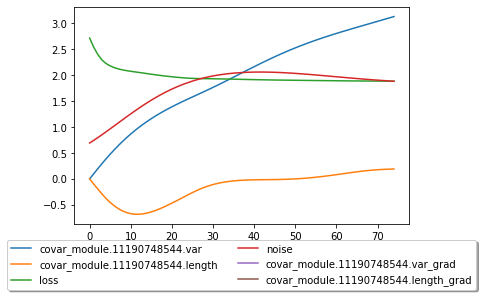

In [12]:
for param_key in param_dict:
    if param_key == 'task_noises':
        pass
    else:
        plt.plot(param_dict[param_key], label=param_key)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)


In [13]:
print(likelihood.noise)
print(likelihood.task_noises)

tensor([1.8804], grad_fn=<AddBackward0>)
tensor([1.0000e-04, 1.0000e-04], grad_fn=<AddBackward0>)


In [14]:
A = matrix(QQ, 4, 4, (2,0,0.6065,0.6065,0,1,-0.6065,0.6065,0.6065,-0.6065,2,0,0.6065,0.6065,0,1))
L = A.cholesky()
L*L.transpose()

[  2.000000000000000?                    0  0.6065000000000000?  0.6065000000000000?]
[                   0                    1 -0.6065000000000000?  0.6065000000000000?]
[ 0.6065000000000000? -0.6065000000000000?   2.000000000000000?              0.?e-18]
[ 0.6065000000000000?  0.6065000000000000?              0.?e-18   1.000000000000000?]

In [15]:
for parameter in model.named_parameters():
    print(parameter)

('likelihood.raw_task_noises', Parameter containing:
tensor([-inf, -inf], requires_grad=True))
('likelihood.raw_noise', Parameter containing:
tensor([1.7148], requires_grad=True))
('covar_module.11190748544.var', Parameter containing:
tensor(3.1565, requires_grad=True))
('covar_module.11190748544.length', Parameter containing:
tensor(0.1919, requires_grad=True))


In [16]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots

number_of_samples = int(120)
# Make predictions
with torch.no_grad():#, gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(float(-2), float(7), number_of_samples)
    #pdb.set_trace()
    outputs = model(test_x)
    predictions = likelihood(outputs)
    
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
#print(mean)
#print(lower)
#print(upper)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

#dims = int(2)
#indices = [list(range(i, len(train_y), dims)) for i in range(dims)]


tensor([[ 23.4883,  16.0016,  23.4750,  ...,  -6.9903,   6.0134,  -7.0669],
        [ 16.0016,  32.7036,  15.9744,  ..., -17.2557,  -7.0669, -16.5343],
        [ 23.4750,  15.9744,  23.4883,  ...,  -6.8849,   6.3537,  -6.9903],
        ...,
        [ -6.9903, -17.2557,  -6.8849,  ...,  32.7036,  15.9744,  32.6109],
        [  6.0134,  -7.0669,   6.3537,  ...,  15.9744,  23.4883,  16.0016],
        [ -7.0669, -16.5343,  -6.9903,  ...,  32.6109,  16.0016,  32.7036]])
torch.return_types.eig(
eigenvalues=tensor([[ 1.3028e+03,  0.0000e+00],
        [ 9.1364e+02,  0.0000e+00],
        [ 4.2155e+02,  0.0000e+00],
        [ 7.3789e+01,  0.0000e+00],
        [ 8.7094e+01,  0.0000e+00],
        [ 9.9777e+00,  0.0000e+00],
        [ 7.2270e-01,  0.0000e+00],
        [ 3.5624e-02,  0.0000e+00],
        [ 1.4018e-03,  0.0000e+00],
        [ 5.2653e-05,  0.0000e+00],
        [-5.1899e-05,  0.0000e+00],
        [-4.4254e-05,  2.0701e-05],
        [-4.4254e-05, -2.0701e-05],
        [-2.2512e-05,  3.1

Text(0.5, 1.0, 'Observed Values (Likelihood)')

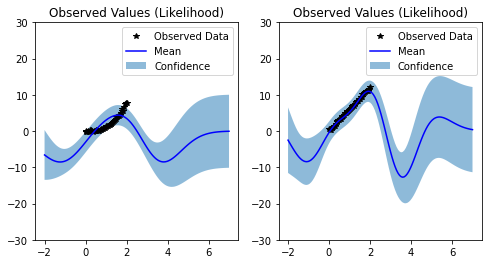

In [17]:
f, (y1_ax, y2_ax) = plt.subplots(int(1), int(2), figsize=(int(8), int(4)))

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-30, 30])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-30, 30])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


In [18]:
a = matrix(1, 2, (1, 2))
b = matrix(2, 2, (1, 2, 3, 4))
a*b

[ 7 10]

# Test Diffable SE Kernel

In [19]:
X = torch.tensor([int(1), int(2), int(3)])
X

tensor([1, 2, 3])

In [20]:
X = torch.linspace(float(-2), float(2), int(1))

In [21]:
x1, x2, l, sigma = var('x1, x2, l, sigma')
lengthscale = 1
variance = 1
SE(x1, x2, l, sigma) = sigma^2*exp(-(x1-x2)^2/(2*l^2))
cov_matr = [[None for i in range(len(X))] for j in range(len(X))]
for i, (v1, v2) in enumerate(product(X, X)):
    cov_matr[int(i/len(X))][int(i%len(X))] = float(SE.diff(x2).diff(x1).diff(x1).diff(x2)(int(v1), int(v2), lengthscale, variance))
cov_matr

[[3.0]]

In [22]:
def coeffs(given_n):
    # See http://oeis.org/A096713
    real_n = int(given_n/2)
    m, k = var('m, k')
    # even
    # T(2*m, k) = (-1)^(m+k)*(2*m)!*2^(k-m)/((m-k)!*(2*k)!), k = 0..m.
    if given_n % 2 == 0:
        # This notation is only valid in iPython
        #T(m,k) = factorial(2*m)*2^(k-m)/(factorial(m-k)*factorial(2*k))
        # As an actual Python file I need to use:
        T = lambda m, k : (-1)**(m+k)*factorial(2*m)*2**(k-m)/(factorial(m-k)*factorial(2*k))
    # odd
    # T(2*m+1, k) = (-1)^(m+k)*(2*m+1)!*2^(k-m)/((m-k)!*(2*k+1)!), k = 0..m. (End)
    else:
        # See above
        #T(m,k) = factorial(2*m+1)*2^(k-m)/(factorial(m-k)*factorial(2*k+1))
        T = lambda m, k: (-1)**(m+k)*factorial(2*m+1)*2**(k-m)/(factorial(m-k)*factorial(2*k+1))

    return [int(T(real_n, k)) for k in range(real_n+1)]


In [23]:
for n in range(13): 
    print(f"{n}: {coeffs(n)}")

0: [1]
1: [1]
2: [-1, 1]
3: [-3, 1]
4: [3, -6, 1]
5: [15, -10, 1]
6: [-15, 45, -15, 1]
7: [-105, 105, -21, 1]
8: [105, -420, 210, -28, 1]
9: [945, -1260, 378, -36, 1]
10: [-945, 4725, -3150, 630, -45, 1]
11: [-10395, 17325, -6930, 990, -55, 1]
12: [10395, -62370, 51975, -13860, 1485, -66, 1]


In [24]:
kernel = Diff_SE_kernel(var=0, length=0)
kernel2 = Diff_SE_kernel(var=0, length=0)
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (1, 0, dx1^3, 1))
R = matrix(2, 2, (1, dx2^2, 0, 1))
p = DiffMatrixKernel([[kernel, None], [None, None]])
cov_mod = p.diff(left_matrix=L, right_matrix=R)
print(cov_mod)

List of all kernels: [Diff_SE_kernel()]
[[diffed_SE_kernel(), diffed_SE_kernel()], [diffed_SE_kernel(), diffed_SE_kernel()]]
[0,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 0]]
Resulting list (including parameters):
 > Summand 0, entry 0:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:1
l exponent:0
(x1-x2) exponent:0


[0,1]: Received derivation form: [[[tensor(1.), tensor(1.)], 0, 2]]
Resulting list (including parameters):
 > Summand 0, entry 0:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:1
l exponent:1
(x1-x2) exponent:0
 > Summand 0, entry 1:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:-1
l exponent:2
(x1-x2) exponent:2


[1,0]: Received derivation form: [[[tensor(1.), tensor(1.)], 3, 0]]
Resulting list (including parameters):
 > Summand 0, entry 0:
polynom coefficients:[tensor(1.), tensor(1.)]
derivation coefficient:-3
l exponent:2
(x1-x2) exponent:1
 > Summand 0, entry 1:
polynom coefficients:

In [25]:
print(SE)
#print(SE.diff(x1).diff(x2))
#print(SE.diff(x1).diff(x2))
print(SE.diff(x1).diff(x2).diff(x1).diff(x2).diff(x1))
#print(SE.diff(x1).diff(x2).diff(x1).diff(x2))
#float(SE.diff(x2).diff(x1)(float(1.), float(1.), 1, 1))

(x1, x2, l, sigma) |--> sigma^2*e^(-1/2*(x1 - x2)^2/l^2)
(x1, x2, l, sigma) |--> -15*sigma^2*(x1 - x2)*e^(-1/2*(x1 - x2)^2/l^2)/l^6 + 10*sigma^2*(x1 - x2)^3*e^(-1/2*(x1 - x2)^2/l^2)/l^8 - sigma^2*(x1 - x2)^5*e^(-1/2*(x1 - x2)^2/l^2)/l^10


In [26]:
a = Diff_SE_kernel(var=int(variance), length=int(lengthscale))
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx2
right_poly = dx1^3 
diffed_kernel = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
left_poly = dx2
right_poly = 1
diffed_kernel2 = a.diff(left_poly=left_poly, right_poly=right_poly, left_d_var=var('dx2'), right_d_var=var('dx1'))
diffed_kernel(X).evaluate() + diffed_kernel2(X).evaluate()

TypeError: Integer.degree() takes no arguments (1 given)

In [ ]:
def calc_cell_diff(L, M, R, context=None):
    len_M = np.shape(M)[0]
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
       map(list, itertools.zip_longest(*M, fillvalue=None)))
    for r_elem, row_M in zip(R, M_transpose):
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                if m_elem is not None:
                    temp = l_elem * m_elem*r_elem
                    #temp = l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
            else:
                if m_elem is not None:
                #if M_transpose[int(j/len_M)][j % len_M] is not None:
                    temp += l_elem * m_elem*r_elem
                    #temp += l_elem * M_transpose[int(j/len_M)][j % len_M]*r_elem
                else:
                    pass
    return temp.simplify_full()


In [ ]:
dimension = 3
length = dimension*dimension +1
L_list = [var(f'l_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
M_list = [var(f'm_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
R_list = [var(f'r_{i}{j}') for i in range(1, dimension+1) for j in range(1, dimension+1)]
L = matrix(dimension, dimension, L_list)
M = matrix(dimension, dimension, M_list)
R = matrix(dimension, dimension, R_list)
print(L)
print(M)
print(R)
row = 0
col = 0
for row in range(dimension):
    for col in range(dimension):
        print((L*M*R)[row][col])
print("\n\n")
for i, (l, r) in enumerate(itertools.product(L.rows(), R.columns())):

    print(calc_cell_diff(l, M, r))
    print("\n")

In [ ]:
def calc_cell_diff_sage(L, M, R, context=None):
    temp = None
    # https://stackoverflow.com/questions/6473679/transpose-list-
    # of-lists
    M_transpose = list(
        map(list, itertools.zip_longest(*M, fillvalue=None)))
    # Every row in 'M' is combined with each elem of the row given in 'R'
    # Or: For each elemtn in row 'R' combine with 'row_M'
    for r_elem, row_M in zip(R, M_transpose):
        # Each element in L gets exactly one element in 'row_M' to multiply
        # Or: Combine each element in row_M with exactly one element in 'L'
        for l_elem, m_elem in zip(L, row_M):
            if temp is None:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp = m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp = m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp = m_elem.diff(l_elem)
                else:
                    pass
            else:
                if m_elem is not None:
                    if not l_elem == 0 and not r_elem == 0:
                        temp += m_elem.diff(l_elem).diff(r_elem)
                    #elif l_elem == 0 and not r_elem == 0:
                    #    temp += m_elem.diff(r_elem)
                    #elif not l_elem == 0 and r_elem == 0:
                    #    temp += m_elem.diff(l_elem)
                    
                else:
                    pass
    return temp

def diff_sage(matrix, left_matrix=None, right_matrix=None):
    # iterate left matrix by rows and right matrix by columns and call the
    # respective diff command of the kernels with the row/cols as params
    kernel = MatrixKernel(None)
    output_matrix = [[0 for i in range(np.shape(matrix)[1])] for j in range(np.shape(matrix)[0])]
    for i, (l, r) in enumerate(itertools.product(left_matrix.rows(), right_matrix.columns())):
        res = calc_cell_diff_sage(l, matrix, r, context=kernel)
        output_matrix[int(i/np.shape(matrix)[0])][
                    int(i % np.shape(matrix)[0])]  = res
    kernel.set_matrix(output_matrix)
    return output_matrix


In [ ]:
import pprint
L = matrix(2, 2, (x1, x1, 0, x1))
R = matrix(2, 2, (x2, 0, x2, x2))
x1, x2, l, sigma, l2, sigma2 = var('x1, x2, l, sigma, l2, sigma2')
lengthscale = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance = 1
lengthscale2 = torch.nn.functional.softplus(torch.tensor(float(0.0)))
variance2 = 1
SEKernelMatrix = [[sigma^2*exp(-(x1-x2)^2/(2*l^2)), sigma2^2*exp(-(x1-x2)^2/(2*l2^2))], [sigma2^2*exp(-(x1-x2)^2/(2*l2^2)), sigma^2*exp(-(x1-x2)^2/(2*l^2))]]
#diffed_SE_sage_matrix_kernel = diff_sage(SEKernelMatrix, left_matrix=L, right_matrix=R)
#pprint.pprint(diffed_SE_sage_matrix_kernel)
cov_matr = [[None for i in range(len(X)*len(SEKernelMatrix))] for j in range(len(X)*len(SEKernelMatrix))]
for i, (v1, v2) in enumerate(product(X, X)):
    for row in range(len(SEKernelMatrix)):
        for col in range(len(SEKernelMatrix)):
            # Blockwise
            #cov_matr[int(i/len(X))+row*len(X)][int(i%len(X))+col*len(X)] = SEKernelMatrix[row][col].substitute(x1=int(v1), x2=int(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2)
            # Interleaved
            text=f"x-pos: {int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row}" +\
            f" y-pos: {int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))}" + \
            f" x1, x2: {v1}, {v2}\n" +\
            f"(x1-x2)^2: {(v1-v2)**2}"+\
            f" exp((x1-x2)^2): {np.exp((v1-v2)**2)}\n"+\
            f"val: {float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))}"
            print(text)
            print("---")
            cov_matr[int(((i*len(SEKernelMatrix))+row)/(len(X)*len(SEKernelMatrix)))*2+row][int((i*len(SEKernelMatrix))+col)%(len(X)*len(SEKernelMatrix))] = float(SEKernelMatrix[row][col].substitute(x1=float(v1), x2=float(v2), l=float(lengthscale), sigma=variance, l2=float(lengthscale2), sigma2=variance2))
cov_matr


In [ ]:
print(X)
print(torch.Tensor(cov_matr).eig())

In [ ]:
exp(-(-2-0.66)^2/(2))

In [ ]:

kernel = Diff_SE_kernel()
kernel2 = Diff_SE_kernel()
q, dx1, dx2 = var('q, dx1, dx2')
L = matrix(2, 2, (dx1, dx1, 0, dx1))
R = matrix(2, 2, (dx2, 0, dx2, dx2))

p = DiffMatrixKernel([[kernel, None], [None, kernel2]])
covar_module = p.diff(left_matrix=L, right_matrix=R)

covar_x = covar_module(X)
covar_x.evaluate()

In [ ]:
matr = [[2, 0, -6*e^(-2), 1, e^(-1/2), -e^(-2)],
 [0, 2, 0, -e^(-1/2), 1, e^(-1/2)],
 [-6*e^(-2), 0, 2, -5*e^(-2), -e^(-1/2), 1],
 [1, e^(-1/2), -e^(-2), 1, 0, -3*e^(-2)],
 [-e^(-1/2), 1, e^(-1/2), 0, 1, 0],
 [-5*e^(-2), -e^(-1/2), 1, -3*e^(-2), 0, 1]]

matr = [[2, 0, -6*e^(-2), 1, 0, -3*e^(-2)],
 [0, 2, 0, 0, 1, 0],
 [-6*e^(-2), 0, 2, -3*e^(-2), 0, 1],
 [1, 0, -3*e^(-2), 1, 0, -3*e^(-2)],
 [0, 1, 0, 0, 1, 0],
 [-3*e^(-2), 0, 1, -3*e^(-2), 0, 1]]

matr = torch.Tensor(matr)
import pprint
pprint.pprint(matr)
print(matr[0::3, 0::3])
H_x = 3
torch.vstack([torch.hstack([matr[k::H_x, l::H_x] for l in range(H_x)]) for k in range(H_x)])

In [ ]:
class testobject():
    def __init__(self, val):
        self.val = val
    
    def setVal(self, val):
        self.val = val
        
    def printVal(self):
        return self.val
    
    def __call__(self):
        return self.val

In [ ]:
t1 = testobject(42)
t2 = testobject(21)
t3 = testobject(17)
l = [[t1, t2], [t2, t3]]
print(l)
t2.setVal(170)
print(l[0][1].printVal())
print(l[1][0].printVal())

In [ ]:
q, dx1, dx2 = var('q, dx1, dx2')
left_poly = dx1
right_poly = dx2
L = matrix(2, 2, (dx1, 0, 0, dx1))
R = matrix(2, 2, (dx2, 0, 0, dx2))

In [ ]:
p.diff(left_matrix=L, right_matrix=R).forward(X, X)

In [ ]:
w, q, dx1, dx2 = var('w, q, dx1, dx2')
a = dx1^2
#a.degree(dx1)
a.operands()

In [ ]:
prod([1,2,3])

In [ ]:
a = torch.Tensor([[int(1), int(2), int(3)], [int(4), int(5), int(6)], [int(7), int(8), int(9)]])
for i, row in enumerate(a):
    for j, elem in enumerate(row[i:]):
        print(f"row: {i}, col: {i+j}")
        print(elem)

In [ ]:
a, b, c, d = var('a, b, c, d')
A = matrix(2,2, (a, b, c, d))
B = matrix(2, 2, (dx1, dx1, 0, dx1))
C = matrix(2, 2, (dx2, 0, dx2, dx2))
print(A)
print(B)
B*A

In [ ]:
a, b, c, d, x, y, dx1 = var('a, b, c, d, x, y, dx1')
poly = (a*(2*(c+b)+a)+a)*y
#poly = a*b*dx1**3
print(type(poly))
#poly = 839840583*x^75
print(poly.degree(dx1))
print(poly.operands())
print([op.is_numeric() for op in poly.operands()])

In [ ]:
return_list = []
l1 = [[42, 17], [128, 256]]
for i, l in enumerate(l1):
    if i == 0:
        func1 = lambda : l[0]*l[1]
        return_list.append(func1)
    else: 
        func2 = lambda : l[0]*l[1]
        return_list.append(func2)

for func in return_list:
    print(func())